In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
sns.set()
warnings.simplefilter('ignore')
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import average_precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/data Paysim/pysim.csv')
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
data.shape


(6362620, 11)

In [ ]:
data.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
# Correcting inconsistency in column name
data = data.rename(columns={'oldbalanceOrg':'oldbalanceOrig'})

In [ ]:
# Transform categorical feature(s) to numeric
le = LabelEncoder()
data.type = le.fit_transform(data.type)

In [ ]:
data.drop(columns=['nameDest', 'nameOrig'], axis=1, inplace=True)
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(4)
memory usage: 436.9 MB


(6362620, 9)

In [ ]:
X = data.drop('isFraud', axis=1)
Y = data['isFraud']
x = StandardScaler().fit_transform(X)


In [ ]:
# Fit PCA on X_features 
from sklearn.decomposition import PCA 
pca = PCA(n_components = 8)

transformed_data = pca.fit_transform(x)
print(transformed_data.shape)
print(pca.explained_variance_ratio_*100)
print(pca.explained_variance_)

(6362620, 8)
[2.90600080e+01 2.61973911e+01 1.25439355e+01 1.24482966e+01
 1.10888124e+01 8.56022975e+00 8.78008016e-02 1.35258898e-02]
[2.32480100e+00 2.09579162e+00 1.00351500e+00 9.95863886e-01
 8.87105131e-01 6.84818488e-01 7.02406523e-03 1.08207135e-03]


0.9998647411021092


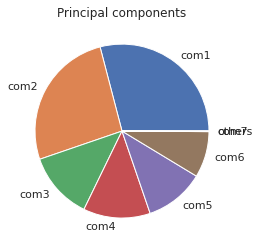

In [ ]:
# Plot the principal components in pie chart, and only keep the components that 
# contains 95% information of original dataset.
threshold = 0.95
for_test = 0
order = 0 
for index, ratio in enumerate(pca.explained_variance_ratio_):
    if threshold > for_test:
        for_test += ratio 
    else:
        order = index + 1 
        break 

print(pca.explained_variance_ratio_[:order].sum())
com_col = ['com'+ str(i+1) for i in range(order)]
com_col.append('others')
com_value = [i for i in pca.explained_variance_ratio_[:order]]
com_value.append(1-pca.explained_variance_ratio_[:order].sum())
plt.figure(figsize=[4,4])
plt.pie(x = com_value, labels = com_col)
plt.title('Principal components')
plt.show()

In [ ]:
#Train Test split
from sklearn.model_selection import train_test_split

# split into 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=1)

# describes info about train and test set
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4453834, 8)
Number transactions y_train dataset:  (4453834,)
Number transactions X_test dataset:  (1908786, 8)
Number transactions y_test dataset:  (1908786,)


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
predictions = lr1.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
acc1 = accuracy_score(y_test, predictions)
prec1 = precision_score(y_test, predictions )
rec1 = recall_score(y_test, predictions )
f11 = f1_score(y_test, predictions )
print('accuracy:%0.4f'%acc1,'\tprecision:%0.4f'%prec1,'\trecall:%0.4f'%rec1,'\tF1-score:%0.4f'%f11)

accuracy:0.9992 	precision:0.9151 	recall:0.4234 	F1-score:0.5789


In [ ]:
results_testset = pd.DataFrame([['Logistic Regression', acc1,  rec1, prec1, f11]],
               columns = ['Model', 'Accuracy',  'Recall', 'Precision', 'F1 Score'])


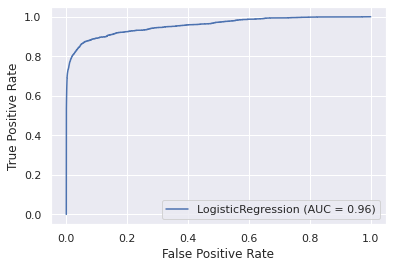

In [ ]:
ROC_RF = plot_roc_curve(lr1, X_test, y_test)
plt.show()

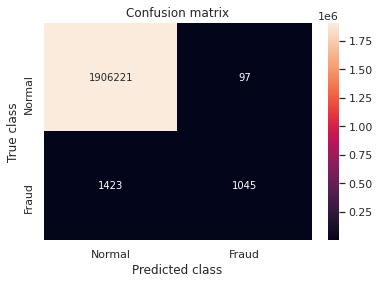

Logistic Regression: 1520
0.9992036823405034
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906318
           1       0.92      0.42      0.58      2468

    accuracy                           1.00   1908786
   macro avg       0.96      0.71      0.79   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 360x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, predictions )
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
n_errors = (predictions  != y_test).sum()
# Run classification metrics
plt.figure(figsize=(5, 4))
print('{}: {}'.format("Logistic Regression", n_errors))
print(accuracy_score(y_test, predictions ))
print(classification_report(y_test, predictions ))

# Random Forest 

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

In [ ]:

acc2 = accuracy_score(y_test, y_pred)
prec2 = precision_score(y_test, y_pred)
rec2 = recall_score(y_test, y_pred)
f12 = f1_score(y_test, y_pred)
print('accuracy:%0.4f'%acc2,'\tprecision:%0.4f'%prec2,'\trecall:%0.4f'%rec2,'\tF1-score:%0.4f'%f12)

accuracy:0.9997 	precision:0.9812 	recall:0.7824 	F1-score:0.8706


In [ ]:
model_results = pd.DataFrame([['Random Forest', acc2,  rec2, prec2, f12]],
               columns = ['Model', 'Accuracy',  'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)


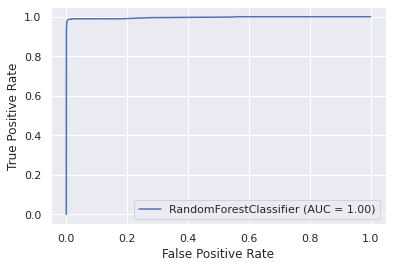

In [ ]:
ROC_RF = plot_roc_curve(clf, X_test, y_test)
plt.show()

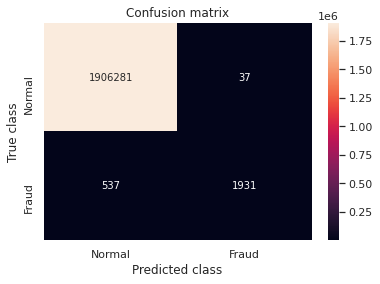

Random Forest: 574
0.9996992853049006
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906318
           1       0.98      0.78      0.87      2468

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 648x504 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix

#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
n_errors = (y_pred != y_test).sum()
# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("Random Forest", n_errors))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
dt= DecisionTreeClassifier()

# Train Decision Tree Classifer
dt = dt.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_dt = dt.predict(X_test)

In [ ]:
acc3 = accuracy_score(y_test, y_pred_dt)
prec3 = precision_score(y_test, y_pred_dt)
rec3 = recall_score(y_test, y_pred_dt)
f13 = f1_score(y_test, y_pred_dt)
print('accuracy:%0.4f'%acc3,'\tprecision:%0.4f'%prec3,'\trecall:%0.4f'%rec3,'\tF1-score:%0.4f'%f13)

accuracy:0.9997 	precision:0.8791 	recall:0.8752 	F1-score:0.8772


In [ ]:
model_results = pd.DataFrame([['Decision Tree', acc3,  rec3, prec3, f13]],
               columns = ['Model', 'Accuracy',  'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)

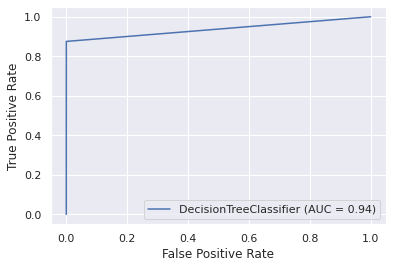

In [ ]:
ROC_RF = plot_roc_curve(dt, X_test, y_test)
plt.show()

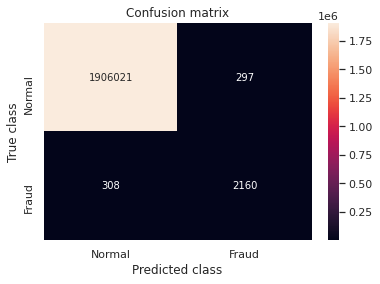

Decision Tree: 605
0.9996830446157925
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906318
           1       0.88      0.88      0.88      2468

    accuracy                           1.00   1908786
   macro avg       0.94      0.94      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 648x504 with 0 Axes>

In [ ]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred_dt )
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
n_errors = (y_pred_dt  != y_test).sum()
# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("Decision Tree", n_errors))
print(accuracy_score(y_test, y_pred_dt ))
print(classification_report(y_test,y_pred_dt ))

# Naive Bayes

In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian C0.
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y4= gnb.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
acc6 = accuracy_score(y_test, y4)
prec6 = precision_score(y_test, y4)
rec6 = recall_score(y_test, y4)
f16 = f1_score(y_test, y4)
print('accuracy:%0.4f'%acc6,'\tprecision:%0.4f'%prec6,'\trecall:%0.4f'%rec6,'\tF1-score:%0.4f'%f16)

accuracy:0.9970 	precision:0.0675 	recall:0.1049 	F1-score:0.0822


In [ ]:
model_results = pd.DataFrame([['Naive Bayes', acc6,  rec6, prec6, f16]],
               columns = ['Model', 'Accuracy',  'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)

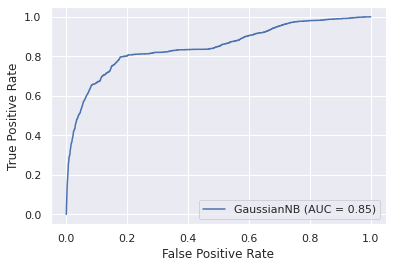

In [ ]:
ROC_RF = plot_roc_curve(gnb, X_test, y_test)
plt.show()

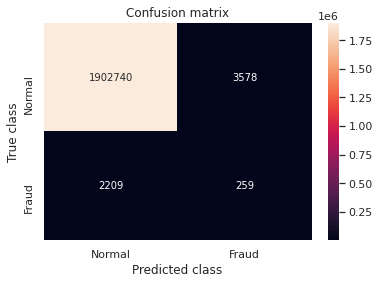

Naive Bayes: 5787
0.9969682300687452
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906318
           1       0.07      0.10      0.08      2468

    accuracy                           1.00   1908786
   macro avg       0.53      0.55      0.54   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 648x504 with 0 Axes>

In [ ]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y4)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
n_errors = (y4 != y_test).sum()
# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("Naive Bayes", n_errors))
print(accuracy_score(y_test, y4))
print(classification_report(y_test, y4))

In [ ]:
results_testset

,Model,Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.999204,0.423420,0.915061,0.578947
1,Random Forest,0.999699,0.782415,0.981199,0.870604
2,Decision Tree,0.999683,0.875203,0.879121,0.877157
3,Naive Bayes,0.996968,0.104943,0.067501,0.082157


# XGBoost

In [ ]:


#Create a svm Classifier
clf2  =  XGBClassifier()
 
#Train the model using the training sets
clf2.fit(X_train, y_train)

#Predict the response for test dataset
y1 = clf2.predict(X_test)

[14:25:16] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
acc4 = accuracy_score(y_test, y1)
prec4 = precision_score(y_test, y1)
rec4 = recall_score(y_test, y1)
f14= f1_score(y_test, y1)
print('accuracy:%0.4f'%acc4,'\tprecision:%0.4f'%prec4,'\trecall:%0.4f'%rec4,'\tF1-score:%0.4f'%f14)

accuracy:0.9996 	precision:0.9829 	recall:0.6746 	F1-score:0.8001


In [ ]:
model_results = pd.DataFrame([['XGBoost', acc4,  rec4, prec4, f14]],
               columns = ['Model', 'Accuracy',  'Recall', 'Precision', 'F1 Score'])
results_testset = results_testset.append(model_results, ignore_index = True)

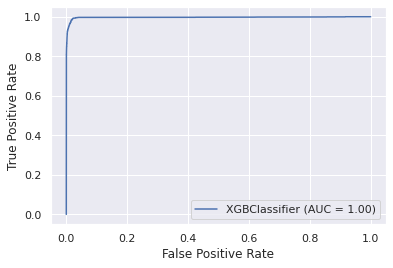

In [ ]:
ROC_RF = plot_roc_curve(clf2, X_test, y_test)
plt.show()

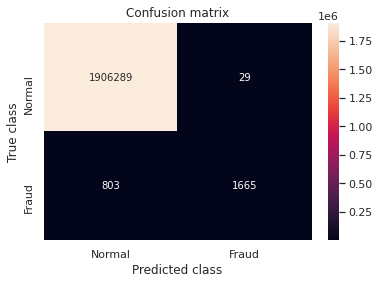

SVM: 832
0.999564120860065
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906318
           1       0.98      0.67      0.80      2468

    accuracy                           1.00   1908786
   macro avg       0.99      0.84      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786



<Figure size 648x504 with 0 Axes>

In [ ]:
#printing the confusion matrix
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, y1)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
n_errors = (y1 != y_test).sum()
# Run classification metrics
plt.figure(figsize=(9, 7))
print('{}: {}'.format("SVM", n_errors))
print(accuracy_score(y_test, y1))
print(classification_report(y_test, y1))

In [ ]:
results_testset

,Model,Accuracy,Recall,Precision,F1 Score
0,Logistic Regression,0.999204,0.423420,0.915061,0.578947
1,Random Forest,0.999699,0.782415,0.981199,0.870604
2,Decision Tree,0.999683,0.875203,0.879121,0.877157
3,Naive Bayes,0.996968,0.104943,0.067501,0.082157
4,XGBoost,0.999564,0.674635,0.982881,0.800096
